In [3]:
#Note - run cells in the below order (and do not re-run them individually)
#     - place csv files in the same folder as the jupyter notebook  

import csv #importing required libraries
from scipy.stats import multivariate_normal
from collections import defaultdict
import calendar
import matplotlib.pyplot as plt
import numpy as np



with open('Monthly_data_cmo.csv', newline='') as csvfile: #import monthly data as nested dictionary
    
    APMC = csv.reader(csvfile)
    
    APMC_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int)))))))
    
    month_to_num = {name: num for num, name in enumerate(calendar.month_name) if num} #dictionary to convert month names to numbers
    
    APMC_district_name_commodity = set() #set containing the combination of districts, names and commodities present in dataset

    
    i=0
    for row in APMC:
        if i > 0: #do not import first row (they are the names of the columns)
            a=[]
            for k in range(4,8):
            
                try: 
                    a.append(int(row[k])) #import the [arrivals_in_qtl, min_price, max_price, modal_price] as a feature vector
                except: #if data point does not exist assign a 0 to it
                    a.append(0)
            
            #defining set elements
            APMC_district_name_commodity.add((row[9].lower(),row[0].lower(),row[1].lower()))
            
            #defining dictionary elements
            APMC_data[row[10].lower()][row[9].lower()][row[0].lower()][row[1].lower()][int(row[2])][month_to_num[row[3]]] = a

                
        i+=1
        

    

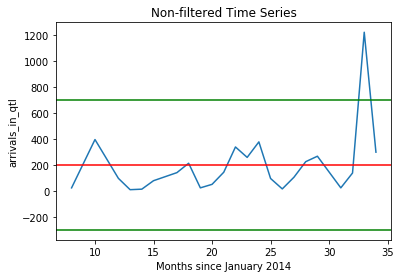

In [4]:
#plotting time series for specific APMC to observe the data before filtering

months = range(1,13)
years = range(2014, 2017)
y=[]
for year in years: #iterate over years and months and append arrivals_in_qtl to vector

    for month in months:

        y.append(APMC_data['maharashtra']['ahmadnagar']['ahmednagar']['bajri'][year][month][0])
                    
x_axis = [i for i, e in enumerate(y) if e != 0]
y_axis= list(filter(lambda a: a != 0, y))
y_mean = np.mean(y_axis)
y_std = np.std(y_axis)


plt.plot(x_axis, y_axis)
plt.axhline(y=y_mean, color='r', linestyle='-') #time series with x axis showing time in months since 2014
plt.axhline(y=y_mean+ 2*y_std, color='g', linestyle='-') #two standard deviations above mean
plt.axhline(y=y_mean- 2*y_std, color='g', linestyle='-') #two standard deviations below mean
plt.xlabel('Months since January 2014')
plt.ylabel('arrivals_in_qtl')
plt.title('Non-filtered Time Series')

plt.show()


In [5]:
#multidimensional outlier detection (for 4D feature vectors as defined above) by constructing a
#multivariate gaussian distribution modelling the variation in the vector for each APMC and commodity over time


for district_name_commodity in APMC_district_name_commodity: #iterating over APMC name district and commodity tuples from set
    months = range(1,13) #iterate over all months
    years = range(2014, 2017) #iterate over years from 2014 to 2016
    y=[ [] for i in range(4) ]
    for year in years:

        for month in months:
            
            #create feature vectors for each time point (i.e. month)        
            y[0].append(APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][0])
            y[1].append(APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][1])
            y[2].append(APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][2])
            y[3].append(APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][3])

    
    
    
    y = np.array(y) #convert list to numpy array
    
    
    x_axis=np.nonzero(y[0]) #only take non zero entries (i.e. month year couples for which we have data)
    
    y_axis = y[:,x_axis[0]] #array slicing so that we only take the non-zero entries
    
    if y_axis.shape[1] > 1: #if we have more than one entry for a specific commodity
    

        y_mean = np.mean(y_axis, axis=1) #compute mean of the collected feature vectors
        y_cov = np.cov(y_axis) #compute covariance of the collected feature vectors


        probability = []

        try:

            for i in range(y_axis.shape[1]):
                var = multivariate_normal(mean=y_mean, cov=y_cov) #compute the probability of each feature vector according to 
                probability.append(var.pdf(y_axis[:,i]))          #multivariate distribution defined by the mean and covariance vector

            normalised_probability = probability/max(probability) #normalise the probabilities with respect to maximum probability in array
            

            # save the indexes of feature vectors for which the normalised probability is smaller than 1e-03 (i.e. outliers)
            indexes = [index for index, value in enumerate(normalised_probability) if value < 1e-03 ] 

            

            #iterate over indexes and deduce the year and month that the anomalous feature vectors came from
            for index in indexes:

                if x_axis[0][index] > 23:
                    corresp_year= 2016
                    corresp_month= x_axis[0][index]-23
                elif x_axis[0][index] < 11:
                    corresp_year= 2014
                    corresp_month= x_axis[0][index]+1
                else:
                    corresp_year= 2015
                    corresp_month= x_axis[0][index] -11


                #set anomalous data to zero
                
               
                APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][corresp_year][corresp_month][0] = 0
                APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][corresp_year][corresp_month][1] = 0
                APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][corresp_year][corresp_month][2] = 0
                APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][corresp_year][corresp_month][3] = 0


    
        except: #if the covariance matrix is singular, perform the same algorithm but add a small number to the diagonal
            # of the covariance matrix to make it invertible
        
            probability = []
            y_cov = (y_cov + np.transpose(y_cov))/2 #make sure that the covariance matrix is symmetric (floating point errors can stop this from being true)
            w, v = np.linalg.eig(y_cov)
            c= np.real(max(w)/10000)
            if c!= 0: #in other words if the y_matrix has independent columns (i.e. a maximum eigenvalue != 0)
                y_cov[np.diag_indices_from(y_cov)] += c
                for i in range(y_axis.shape[1]):
                    var = multivariate_normal(mean=y_mean, cov=y_cov)
                    probability.append(var.pdf(y_axis[:,i]))

                normalised_probability = probability/max(probability)

                indexes = [index for index, value in enumerate(normalised_probability) if value < 1e-03 ]

                

                for index in indexes:

                    if x_axis[0][index] > 23:
                        corresp_year= 2016
                        corresp_month= x_axis[0][index]-23
                    elif x_axis[0][index] < 11:
                        corresp_year= 2014
                        corresp_month= x_axis[0][index]+1
                    else :
                        corresp_year= 2015
                        corresp_month= x_axis[0][index] -11

                    

                    APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][corresp_year][corresp_month][0] = 0
                    APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][corresp_year][corresp_month][1] = 0
                    APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][corresp_year][corresp_month][2] = 0
                    APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][corresp_year][corresp_month][3] = 0
            
            else: #either there is not enough data about that specific commodity or its feature vectors remain the same over time
                pass
                        
    else: #if we have only one entry for a specific commodity there can be no outliers!
        pass
        
        
        
    

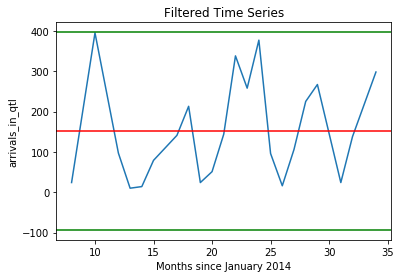

In [6]:
#verifying elimination of outliers (plotting the same time series as before)
#Bajri in Ahmednagar

months = range(1,13)
years = range(2014, 2017)
y=[]
for year in years:

    for month in months:

        y.append(APMC_data['maharashtra']['ahmadnagar']['ahmednagar']['bajri'][year][month][0])
                    
x_axis = [i for i, e in enumerate(y) if e != 0]
y_axis= list(filter(lambda a: a != 0, y))
y_mean = np.mean(y_axis)
y_std = np.std(y_axis)


plt.plot(x_axis, y_axis)
plt.axhline(y=y_mean, color='r', linestyle='-') #time series with x axis showing time in months since 2014
plt.axhline(y=y_mean+ 2*y_std, color='g', linestyle='-') #two standard deviations above mean
plt.axhline(y=y_mean- 2*y_std, color='g', linestyle='-') #two standard deviations below mean
plt.xlabel('Months since January 2014')
plt.ylabel('arrivals_in_qtl')
plt.title('Filtered Time Series')

plt.show()



In [7]:
#write non-zero data to a new file called clean_monthly_data.csv

with open('clean_monthly_data.csv', mode='w', newline='') as clean_data:
    clean_data_writer = csv.writer(clean_data, delimiter=',', quotechar='"', quoting=csv.QUOTE_NONE)
    
    #first row contains titles
    clean_data_writer.writerow(['APMC', 'Commodity', 'Year', 'Month', 'arrivals_in_qtl', 'min_price', 'max_price', 'modal_price', 'date', 'district_name', 'state_name'])
    
    #iterate over datpoints and populate csv file
    for district_name_commodity in APMC_district_name_commodity:
        
        
        months = range(1,13)
        years = range(2014, 2017)
        
        for year in years:
            for month in months:
                
                #only add complete datasets (i.e. with no missing or corrupt values)
                if 0 not in APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month]:
                    
                    # if statement to ensure the correct format of the date entry
                    if month < 10:
                        clean_data_writer.writerow([district_name_commodity[1], district_name_commodity[2], year, month, APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][0], APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][1], APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][2], APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][3], str(year)+'-0'+str(month), district_name_commodity[0], 'maharashtra']) 
                    
                    else:
                        clean_data_writer.writerow([district_name_commodity[1], district_name_commodity[2], year, month, APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][0], APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][1], APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][2], APMC_data['maharashtra'][district_name_commodity[0]][district_name_commodity[1]][district_name_commodity[2]][year][month][3], str(year)+'-'+str(month), district_name_commodity[0], 'maharashtra']) 
                    
                    
                else:
                    pass
    